# Bitácora properati

In [1]:
pip install ydata_profiling scikit-learn folium openpyxl spacy transformers torch pandas numpy regex unidecode

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\facun\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
!python -m spacy download es_core_news_sm

     ---------------------------------------- 12.9/12.9 MB 4.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


You should consider upgrading via the 'c:\Users\facun\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
# Importación de librerías
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import re

c:\Users\facun\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Base test
Levanto la base test y dejo los filtros que corresponden: Venta y USD
Con los filtros nos quedamos con **60.319** registros de **85.528** (70.5%)

In [4]:
# Levantamos .csv
df_test = pd.read_csv("/Users/facun/Desktop/AED 2025/Properati/bd_test.csv", sep=';')

Transformación de las variables

In [5]:
# Convert date columns to datetime objects
df_test['start_date'] = pd.to_datetime(df_test['start_date'], format='%Y-%m-%d', errors='coerce')
df_test['end_date'] = pd.to_datetime(df_test['end_date'], format='%Y-%m-%d', errors='coerce')
df_test['created_on'] = pd.to_datetime(df_test['created_on'], format='%Y-%m-%d', errors='coerce')

# Display the data types to verify the conversion
print(df_test[['start_date', 'end_date', 'created_on']].info())

df_test['start_date'].dt.strftime('%Y/%m/%d').head()
df_test['end_date'].dt.strftime('%Y/%m/%d').head()
df_test['created_on'].dt.strftime('%Y/%m/%d').head()

# Convert 'lat' and 'lon' to numeric, replacing comma with a period
df_test['lat'] = pd.to_numeric(df_test['lat'].str.replace(',', '.'), errors='coerce')
df_test['lon'] = pd.to_numeric(df_test['lon'].str.replace(',', '.'), errors='coerce')

# Display the data types to verify the conversion
print(df_test[['lat', 'lon']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85528 entries, 0 to 85527
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  85528 non-null  datetime64[ns]
 1   end_date    67723 non-null  datetime64[ns]
 2   created_on  85528 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 2.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85528 entries, 0 to 85527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     73099 non-null  float64
 1   lon     73184 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB
None


## Filtros

### Currency=USD y operation_type=Venta

In [6]:
# Filter for operation_type = "Venta" and currency = "USD"
df_test = df_test[(df_test['operation_type'] == 'Venta') & (df_test['currency'] == 'USD')]

# Vista inicial
df_test.head()

# Tamaño del dataset
print("Filas:", df_test.shape[0])
print("Columnas:", df_test.shape[1])

# Tipos de variables
df_test.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df_test.describe().T

Filas: 60319
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
Index: 60319 entries, 0 to 85527
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               60319 non-null  int64         
 1   ad_type          60319 non-null  object        
 2   start_date       60319 non-null  datetime64[ns]
 3   end_date         44344 non-null  datetime64[ns]
 4   created_on       60319 non-null  datetime64[ns]
 5   lat              51736 non-null  float64       
 6   lon              51807 non-null  float64       
 7   l1               60319 non-null  object        
 8   l2               60319 non-null  object        
 9   l3               57619 non-null  object        
 10  l4               20764 non-null  object        
 11  l5               437 non-null    object        
 12  l6               0 non-null      float64       
 13  rooms            46044 non-null  float64       
 14  bedrooms         

,count,mean,min,25%,50%,75%,max,std
id,60319.0,494547.015236,9.0,237974.5,492133.0,752855.5,999986.0,294605.476442
start_date,60319,2020-01-27 09:23:14.247251968,2019-07-04 00:00:00,2019-11-09 00:00:00,2020-02-13 00:00:00,2020-04-11 00:00:00,2020-07-27 00:00:00,NaN
end_date,44344,2020-03-18 17:11:46.620963328,2019-07-05 00:00:00,2019-12-23 00:00:00,2020-04-08 00:00:00,2020-06-15 00:00:00,2020-09-25 00:00:00,NaN
created_on,60319,2020-01-27 09:23:14.247251968,2019-07-04 00:00:00,2019-11-09 00:00:00,2020-02-13 00:00:00,2020-04-11 00:00:00,2020-07-27 00:00:00,NaN
lat,51736.0,-58.495749,-71.356235,-58.555526,-58.446541,-58.400684,-54.692854,0.501442
lon,51807.0,-34.612509,-42.767168,-34.664564,-34.60683,-34.571122,-26.837516,0.258267
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,46044.0,2.999392,1.0,2.0,3.0,4.0,35.0,1.493668
bedrooms,38620.0,2.205256,0.0,1.0,2.0,3.0,77.0,1.374264
bathrooms,56172.0,1.699993,1.0,1.0,1.0,2.0,16.0,1.022667


### Tablas de frecuencia

In [7]:
# Frequency tables for selected variables
selected_cols = ['ad_type','l1','l2','l3','l4','l5','l6','rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered','currency','price_period','operation_type', 'property_type']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_test[col].value_counts()
    relative_frequencies = df_test[col].value_counts(normalize=True) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for ad_type:
           Absolute Frequency  Relative Frequency (%)
ad_type                                              
Propiedad               60319                   100.0


Frequency Table for l1:
           Absolute Frequency  Relative Frequency (%)
l1                                                   
Argentina               60319                   100.0


Frequency Table for l2:
                          Absolute Frequency  Relative Frequency (%)
l2                                                                  
Capital Federal                        27215               45.118454
Bs.As. G.B.A. Zona Norte               13022               21.588554
Bs.As. G.B.A. Zona Sur                 12521               20.757970
Bs.As. G.B.A. Zona Oeste                7460               12.367579
Santa Fe                                  76                0.125997
Córdoba                                   25                0.041446


Frequency Table for l3:
                 

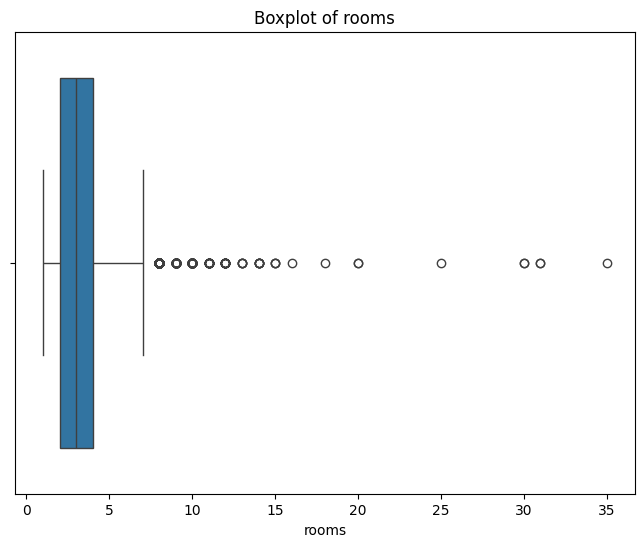

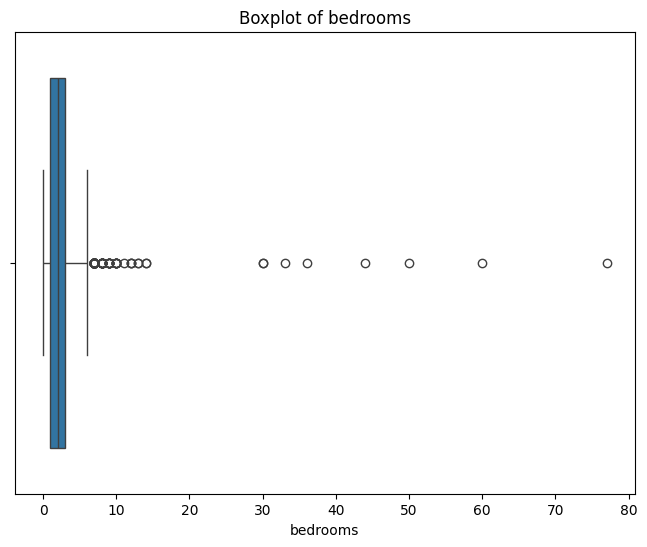

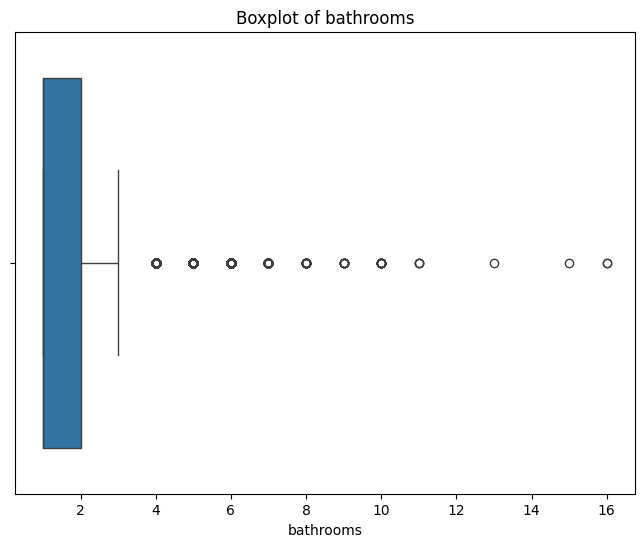

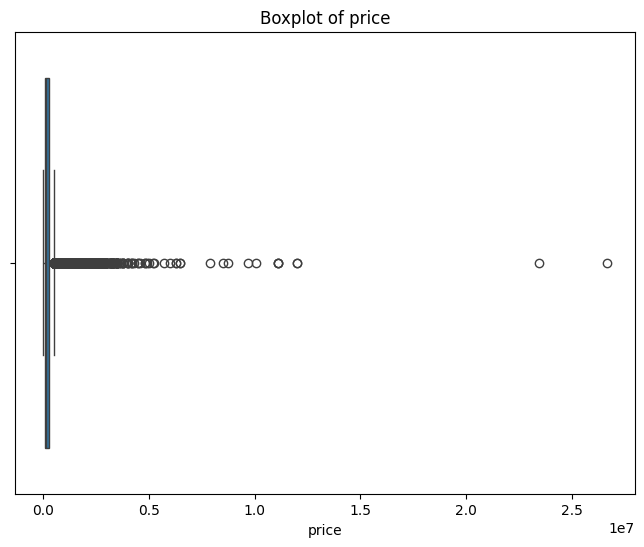

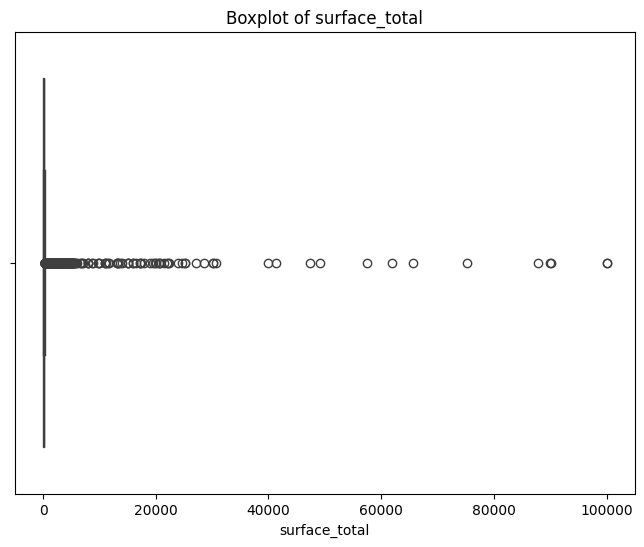

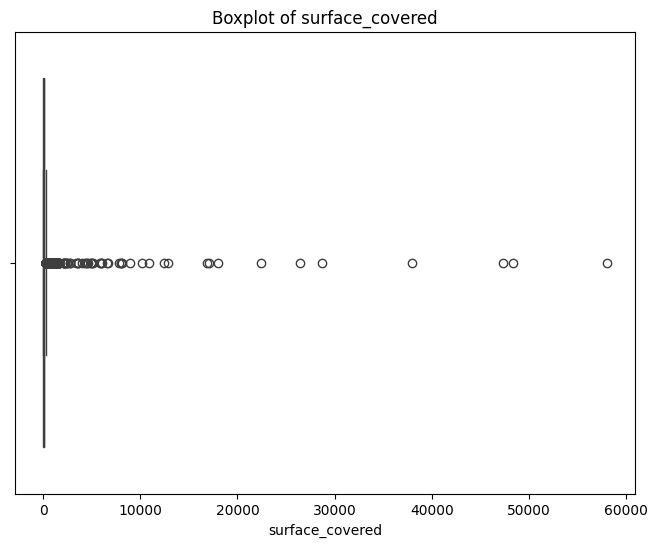

In [8]:
%matplotlib inline
# Select specified numeric columns for visualizations
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

# Generate boxplots for selected numeric variables
for col in numeric_cols_selected:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df_test[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

### Decisión: eliminar las variables ad_type y l6 porque no aportan nada de información

In [9]:
df_test = df_test.drop(columns=['ad_type', 'l6'], errors='ignore')

# Base desarrollo

In [10]:
# Levantamos .csv
df = pd.read_csv("/Users/facun/Desktop/AED 2025/Properati/bd_desarrollo.csv",sep=';')

# Vista inicial
df.head(5)

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,price
0,556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,"-58,4423994000","-34,5736231000",Argentina,Capital Federal,Colegiales,...,2.0,NaN,NaN,USD,NaN,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0
1,192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,"-58,4304928000","-34,6066200000",Argentina,Capital Federal,Almagro,...,2.0,77.0,67.0,USD,NaN,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta,235500.0
2,238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,"-58,4917602500","-34,5741233800",Argentina,Capital Federal,Villa Urquiza,...,1.0,60.0,55.0,USD,NaN,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta,175000.0
3,521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,"-58,4299830000","-34,6072250000",Argentina,Capital Federal,Almagro,...,1.0,66.0,64.0,USD,NaN,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta,173000.0
4,383947,Propiedad,2019-10-23,2019-11-08,2019-10-23,"-58,4207800000","-34,6086400000",Argentina,Capital Federal,Almagro,...,1.0,55.0,55.0,USD,NaN,Depto.tipo casa de 3 ambientes en Venta en Alm...,"Muy Lindo ph al contrafrente con 2 patios!, 80...",PH,Venta,155000.0


# EDA - Base desarrollo

In [11]:
# Tamaño del dataset
print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])

# Tipos de variables
df.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df.describe().T

Filas: 879294
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               879294 non-null  int64  
 1   ad_type          879294 non-null  object 
 2   start_date       879294 non-null  object 
 3   end_date         879294 non-null  object 
 4   created_on       879294 non-null  object 
 5   lat              743531 non-null  object 
 6   lon              744354 non-null  object 
 7   l1               879294 non-null  object 
 8   l2               879294 non-null  object 
 9   l3               827305 non-null  object 
 10  l4               185112 non-null  object 
 11  l5               3781 non-null    object 
 12  l6               0 non-null       float64
 13  rooms            432009 non-null  float64
 14  bedrooms         334687 non-null  float64
 15  bathrooms        681546 non-null  float64
 16  surface_tot

,count,mean,std,min,25%,50%,75%,max
id,879294.0,502302.326894,2.882041e+05,1.0,253101.25,503737.5,752416.75,1.000000e+06
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,432009.0,2.866357,1.701833e+00,1.0,2.00,3.0,4.00,4.000000e+01
bedrooms,334687.0,2.084473,2.751976e+00,-13.0,1.00,2.0,3.00,9.000000e+02
bathrooms,681546.0,1.696844,1.071229e+00,1.0,1.00,1.0,2.00,2.000000e+01
surface_total,384422.0,511.374284,4.244219e+03,-200.0,50.00,95.0,277.00,2.000000e+05
surface_covered,373844.0,637.453502,7.981026e+04,-170.0,45.00,75.0,155.00,2.700000e+07
price,838214.0,295447.634787,5.905478e+06,0.0,39000.00,95000.0,205000.00,3.100000e+09


Transformación del tipo de variable

In [12]:
# Convert date columns to datetime objects
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d', errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d', errors='coerce')
df['created_on'] = pd.to_datetime(df['created_on'], format='%Y-%m-%d', errors='coerce')

# Display the data types to verify the conversion
print(df[['start_date', 'end_date', 'created_on']].info())

df['start_date'].dt.strftime('%Y/%m/%d').head()
df['end_date'].dt.strftime('%Y/%m/%d').head()
df['created_on'].dt.strftime('%Y/%m/%d').head()

# Convert 'lat' and 'lon' to numeric, replacing comma with a period
df['lat'] = pd.to_numeric(df['lat'].str.replace(',', '.'), errors='coerce')
df['lon'] = pd.to_numeric(df['lon'].str.replace(',', '.'), errors='coerce')

# Display the data types to verify the conversion
print(df[['lat', 'lon']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_date  879294 non-null  datetime64[ns]
 1   end_date    711369 non-null  datetime64[ns]
 2   created_on  879294 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 20.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     743531 non-null  float64
 1   lon     744354 non-null  float64
dtypes: float64(2)
memory usage: 13.4 MB
None


## Reporte EDA base original

In [ ]:
## Generate the EDA report
#profile = ProfileReport(df, title="EDA db_desarrollo")
#
## Save the report to an HTML file
#profile.to_file("eda_report_df_desarrollo.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Tabla de frecuencias

In [13]:
# Frequency tables for selected variables
selected_cols = ['l1','rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered','currency','price_period','operation_type', 'property_type']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df[col].value_counts()
    relative_frequencies = df[col].value_counts(normalize=True) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for l1:
                Absolute Frequency  Relative Frequency (%)
l1                                                        
Argentina                   860524               97.865333
Uruguay                      17929                2.039022
Estados Unidos                 783                0.089049
Brasil                          58                0.006596


Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
2.0                118344               27.393874
3.0                109046               25.241604
1.0                 84800               19.629221
4.0                 65682               15.203850
5.0                 29186                6.755878
6.0                 12770                2.955957
7.0                  5780                1.337935
8.0                  2802                0.648598
10.0                 1487                0.344206
9.0                  1049                0.

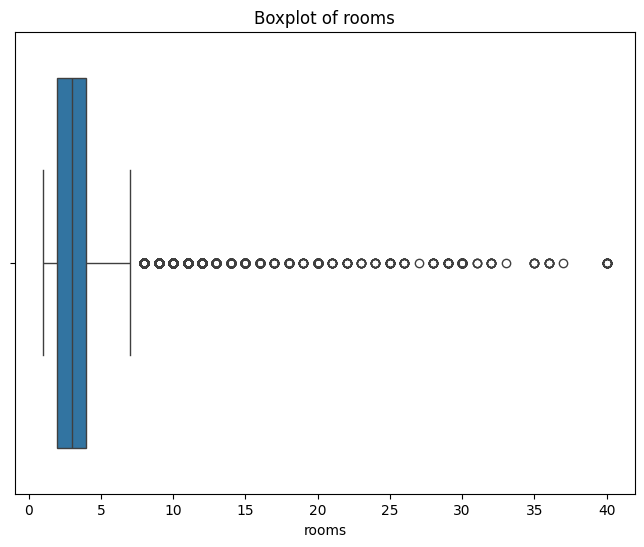

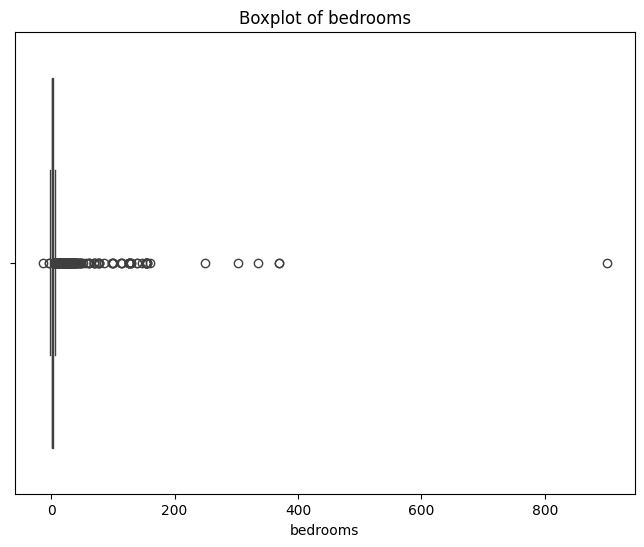

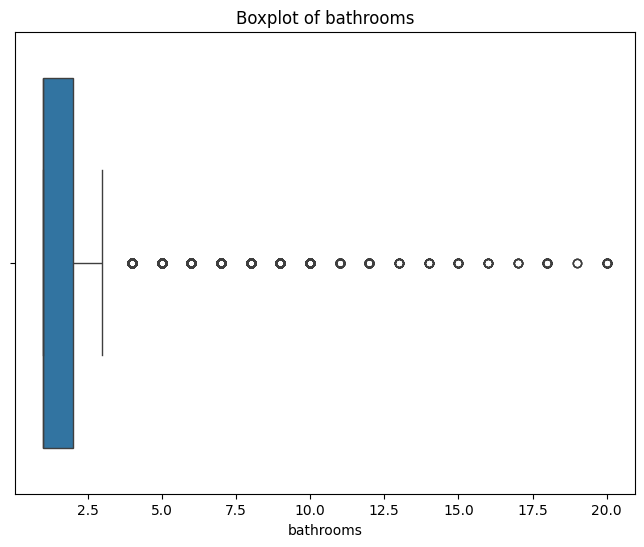

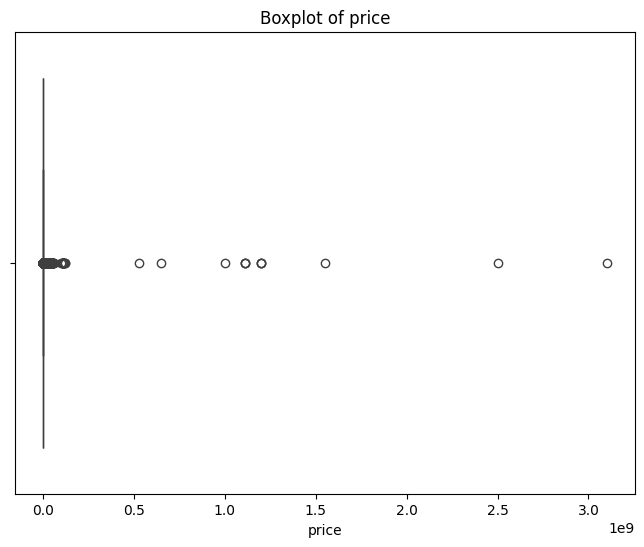

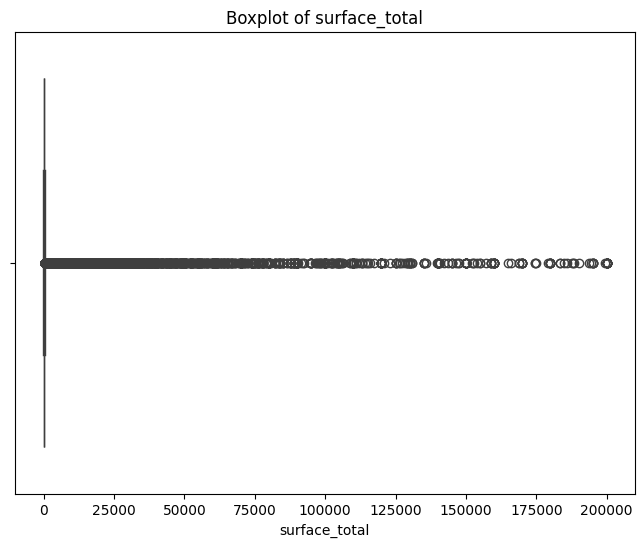

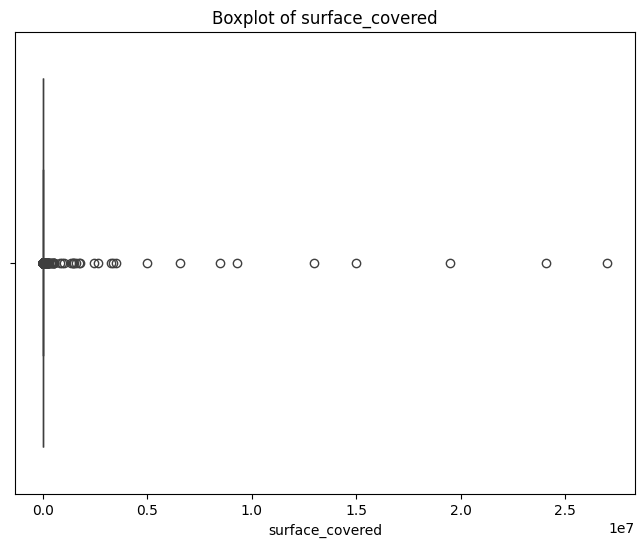

In [14]:
%matplotlib inline
# Select specified numeric columns for visualizations
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

# Generate boxplots for selected numeric variables
for col in numeric_cols_selected:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## Filtros
Originalmete la base train tiene **879.294** registros y 25 variables. Después de aplicar los filtros correspondientes nos quedamos con **289.254** filas (32.9% de los registros)

### operation_type = Ventas

In [15]:
df_ventas = df[df['operation_type'] == 'Venta']
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 679477
Porcentaje sobre el total original (879294): 77.28%


### l1 = Argentina

In [16]:
df_ventas = df_ventas[df_ventas['l1'] == 'Argentina']
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 667853
Porcentaje sobre el total original (879294): 75.95%


### l2 = Capital Federal, Bs.As. G.B.A. Zona Norte, Bs.As. G.B.A. Zona Sur, Bs.As. G.B.A. Zona Oeste, Santa Fe, Córdoba

In [17]:
region = ['Capital Federal','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Oeste','Santa Fe','Córdoba']
df_ventas = df_ventas[df_ventas['l2'].isin(region)]
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 459074
Porcentaje sobre el total original (879294): 52.21%


### l3 = ciudades que están en df_test

In [18]:
valores_unicos_l3 = df_test['l3'].unique().tolist()
df_ventas = df_ventas[df_ventas['l3'].isin(valores_unicos_l3)].copy()
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 421615
Porcentaje sobre el total original (879294): 47.95%


### property_type = Departamento, Casa, PH, Casa de campo

In [19]:
tipos_validos = ['Departamento', 'Casa', 'PH', 'Casa de campo']
df_ventas_sin_otros = df_ventas[df_ventas['property_type'].isin(tipos_validos)]
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 421615
Porcentaje sobre el total original (879294): 47.95%


### DECISIÓN: Quitar las columnas ad_type y l6 porque están vacías

In [20]:
df_ventas_sin_otros = df_ventas_sin_otros.drop(columns=['ad_type', 'l6'], errors='ignore')

In [21]:
# Frequency tables for selected variables
selected_cols = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered','currency','price_period','operation_type', 'property_type']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_sin_otros[col].value_counts(dropna=False)
    relative_frequencies = df_ventas_sin_otros[col].value_counts(normalize=True, dropna=False) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
3.0                 62807               22.677036
2.0                 62787               22.669815
NaN                 46192               16.678040
4.0                 40541               14.637695
1.0                 35427               12.791239
5.0                 16841                6.080596
6.0                  6819                2.462062
7.0                  2901                1.047432
8.0                  1273                0.459628
10.0                  540                0.194972
9.0                   477                0.172225
12.0                  107                0.038633
11.0                   82                0.029607
14.0                   35                0.012637
15.0                   32                0.011554
13.0                   25                0.009026
20.0                   12                0.004333
30.0                   

## Currency= USD o ARS

In [22]:
tipo_moneda = ['USD', 'ARS']
df_ventas_sin_otros = df_ventas_sin_otros[df_ventas_sin_otros['currency'].isin(tipo_moneda)]
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 421615
Porcentaje sobre el total original (879294): 47.95%


### OJO: separo el dataset en Currency USD y ARS

In [23]:
moneda = ['USD']
df_ventas_sin_otros_USD = df_ventas_sin_otros[df_ventas_sin_otros['currency'].isin(moneda)]

In [24]:
df_ventas_sin_otros_USD.describe().T

,count,mean,min,25%,50%,75%,max,std
id,257302.0,477116.98543,5.0,215563.5,466564.5,737887.5,999995.0,293668.600294
start_date,257302,2020-01-21 05:17:03.298692096,2019-07-04 00:00:00,2019-10-25 00:00:00,2020-01-28 00:00:00,2020-04-15 00:00:00,2020-07-27 00:00:00,NaN
end_date,181359,2020-03-14 05:53:29.944915968,2019-07-05 00:00:00,2019-12-22 00:00:00,2020-04-02 00:00:00,2020-06-25 00:00:00,2020-09-25 00:00:00,NaN
created_on,257302,2020-01-21 05:17:03.298692096,2019-07-04 00:00:00,2019-10-25 00:00:00,2020-01-28 00:00:00,2020-04-15 00:00:00,2020-07-27 00:00:00,NaN
lat,223144.0,-59.063551,-180.0,-58.690402,-58.474872,-58.410347,-54.13333,1.563194
lon,223498.0,-34.244574,-53.788249,-34.644995,-34.59527,-34.446201,85.051129,0.987038
rooms,214446.0,2.979552,1.0,2.0,3.0,4.0,40.0,1.533022
bedrooms,173360.0,2.169843,-3.0,1.0,2.0,3.0,900.0,2.782608
bathrooms,241599.0,1.686389,1.0,1.0,1.0,2.0,20.0,1.011397
surface_total,156766.0,220.268247,-200.0,50.0,82.0,180.0,200000.0,1735.799599


In [25]:
moneda = ['ARS']
df_ventas_sin_otros_ARS = df_ventas_sin_otros[df_ventas_sin_otros['currency'].isin(moneda)]

In [26]:
df_ventas_sin_otros_ARS.describe().T

,count,mean,min,25%,50%,75%,max,std
id,6963.0,448379.393652,11.0,192374.5,424509.0,670367.5,999771.0,283996.425803
start_date,6963,2020-01-22 16:48:48.392933888,2019-07-04 00:00:00,2019-10-09 12:00:00,2020-02-01 00:00:00,2020-05-08 00:00:00,2020-07-27 00:00:00,NaN
end_date,4786,2020-02-13 19:59:53.982448896,2019-07-06 00:00:00,2019-10-13 00:00:00,2020-02-22 00:00:00,2020-06-02 00:00:00,2020-09-25 00:00:00,NaN
created_on,6963,2020-01-22 16:48:48.392933888,2019-07-04 00:00:00,2019-10-09 12:00:00,2020-02-01 00:00:00,2020-05-08 00:00:00,2020-07-27 00:00:00,NaN
lat,4925.0,-60.49736,-68.886894,-60.669277,-60.653664,-58.725478,-54.570341,1.826116
lon,4932.0,-33.224834,-38.967398,-34.519687,-32.952007,-32.937008,-25.974415,1.092402
rooms,5862.0,2.053224,1.0,1.0,2.0,2.0,14.0,1.237901
bedrooms,4561.0,1.355405,0.0,1.0,1.0,2.0,9.0,0.790138
bathrooms,6454.0,1.168578,1.0,1.0,1.0,1.0,7.0,0.534069
surface_total,3559.0,106.97415,11.0,39.0,50.0,73.5,11376.0,445.656346


## Reporte EDA con filtros en país (l1), tipo de propiedad (property_type), región (l2), ciudad (l3) y precio (USD o ARS) (filtro_2)

In [35]:
# Generate the EDA report
profile = ProfileReport(df_ventas_sin_otros, title="EDA db_desarrollo_filtro_2")

# Save the report to an HTML file
profile.to_file("eda_report_df_desarrollo_filtro_2.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s]


# Modelo lightgbm base sin modificaciones

## Con escalado

In [27]:
# Importación de librerías
import numpy as np
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [28]:
df_train = df_ventas_sin_otros.copy()
df_train_prueba = df_train[['rooms', 'bathrooms', 'bedrooms', 'surface_covered', 'surface_total', 'price']].head(2000)
df_train_prueba = df_train_prueba.fillna(0)

In [29]:
np.random.seed(42)

# --- Separar features y target ---
y = df_train_prueba['price']
X = df_train_prueba.drop(columns='price')

# --- Validación cruzada ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # --- Escalado opcional (solo train) ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    ## ACÁ TENGO QUE PONER LAS IMPUTACIONES

    # --- Crear objetos LightGBM ---
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)

    # --- Parámetros ---
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    # --- Entrenamiento ---
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    # --- Predicción y RMSE ---
    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.4f}")

print(f"RMSE promedio CV: {np.mean(rmse_scores):.4f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 111074
Fold 1: RMSE = 111073.7846
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 84107.9
Fold 2: RMSE = 84107.9278
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 94255
Fold 3: RMSE = 94254.9621
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76690.1
Fold 4: RMSE = 76690.0662
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 88785.4
Fold 5: RMSE = 88785.4454
RMSE promedio CV: 90982.4372


## Sin escalar (revisar)

In [30]:
# Crear listas para almacenar los resultados completos
resultados_completos = []

rmse_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    #scaler = StandardScaler()
    #X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    #X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    #train_data = lgb.Dataset(X_train_scaled, label=y_train)
    #valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    # Recuperar las filas originales usando valid_idx
    fold_result = df_train_prueba.iloc[valid_idx].copy()
    fold_result['observed'] = y_valid.values
    fold_result['predicted'] = y_pred
    fold_result['error'] = y_valid.values - y_pred
    resultados_completos.append(fold_result)

    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.4f}")

print(f"RMSE promedio CV: {np.mean(rmse_scores):.4f}")

# Concatenar todos los folds
resultados_full = pd.concat(resultados_completos, ignore_index=True)
resultados_full.head()


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 111074
Fold 1: RMSE = 163783.2525
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 84107.9
Fold 2: RMSE = 150495.1825
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 94255
Fold 3: RMSE = 160196.0377
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76690.1
Fold 4: RMSE = 101265.3972
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 88785.4
Fold 5: RMSE = 156078.3145
RMSE promedio CV: 146363.6369


,rooms,bathrooms,bedrooms,surface_covered,surface_total,price,observed,predicted,error
0,3.0,1.0,2.0,46.0,49.0,124000.0,124000.0,83123.653894,40876.346106
1,2.0,2.0,1.0,52.0,54.0,104000.0,104000.0,83123.653894,20876.346106
2,3.0,1.0,2.0,75.0,85.0,230000.0,230000.0,122302.665584,107697.334416
3,3.0,2.0,0.0,85.0,110.0,265000.0,265000.0,105883.934817,159116.065183
4,2.0,1.0,1.0,43.0,46.0,150000.0,150000.0,88289.999847,61710.000153


# Limpieza de datos

## Datos geográficos

### l3

In [31]:
# Frequency tables for selected variables
selected_cols = ['l2','l3','l4']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_sin_otros[col].value_counts(dropna=False)
    relative_frequencies = df_ventas_sin_otros[col].value_counts(normalize=True, dropna=False) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for l2:
                          Absolute Frequency  Relative Frequency (%)
l2                                                                  
Capital Federal                        96234               36.415719
Bs.As. G.B.A. Zona Norte               49115               18.585511
Bs.As. G.B.A. Zona Sur                 44797               16.951545
Santa Fe                               32726               12.383781
Bs.As. G.B.A. Zona Oeste               26247                9.932076
Córdoba                                15146                5.731368


Frequency Table for l3:
                 Absolute Frequency  Relative Frequency (%)
l3                                                         
Rosario                       32042               12.124950
Tigre                         16321                6.175998
Palermo                       13473                5.098291
Córdoba                       12042                4.556790
Lomas de Zamora               11539   

In [38]:
na_count = df_ventas_sin_otros['l3'].isna().sum()
print("Cantidad de NAs en l3:", na_count)


Cantidad de NAs en l3: 10345


#### OPCIONES: 
1) No hacer nada, dejarlos como NA
2) En base a lat y lon asignarle un barrio/localidad/municipio
3) NLP en título o descripción (No creo que tenga sentido)

### lat y lon

#### OPCIÓN 1: En los casos en los cuales estoy segura que están invertidas lat y lon los doy vuelta. Creo lat_ok y lon_ok

In [41]:
def corregir_coords(row):
    lat, lon = row["lat"], row["lon"]
    # Caso normal: lat está en rango [-90, 90]
    if -90 <= lat <= 90:
        return pd.Series([lat, lon])
    # Caso sospechoso: lat está en rango [-180, 180] -> invertimos
    elif -180 <= lat <= 180:
        return pd.Series([lon, lat])
    else:
        return pd.Series([None, None])  # opcional: marcar como inválido

df_ventas_sin_otros[["lat_ok", "lon_ok"]] = df_ventas_sin_otros.apply(corregir_coords, axis=1)

In [42]:
df_ventas_sin_otros.describe().T    

,count,mean,min,25%,50%,75%,max,std
id,264265.0,476359.791509,5.0,214838.0,465431.0,735525.0,999995.0,293453.422287
start_date,264265,2020-01-21 06:13:13.412672768,2019-07-04 00:00:00,2019-10-25 00:00:00,2020-01-28 00:00:00,2020-04-16 00:00:00,2020-07-27 00:00:00,NaN
end_date,186145,2020-03-13 11:44:32.387655168,2019-07-05 00:00:00,2019-12-21 00:00:00,2020-04-01 00:00:00,2020-06-25 00:00:00,2020-09-25 00:00:00,NaN
created_on,264265,2020-01-21 06:13:13.412672768,2019-07-04 00:00:00,2019-10-25 00:00:00,2020-01-28 00:00:00,2020-04-16 00:00:00,2020-07-27 00:00:00,NaN
lat,228069.0,-59.094513,-180.0,-58.703325,-58.478185,-58.411507,-54.13333,1.58311
lon,228430.0,-34.222557,-53.788249,-34.643855,-34.594335,-34.435997,85.051129,1.000468
rooms,220308.0,2.954904,1.0,2.0,3.0,4.0,40.0,1.533172
bedrooms,177921.0,2.148965,-3.0,1.0,2.0,3.0,900.0,2.752633
bathrooms,248053.0,1.672917,1.0,1.0,1.0,2.0,20.0,1.005248
surface_total,160325.0,217.75327,-200.0,50.0,80.0,180.0,200000.0,1717.789722


##### lat y lon dentro de ARG

In [43]:
# Chequeo de rango Argentina
df_ventas_sin_otros["en_argentina"] = (
    (df_ventas_sin_otros["lat_ok"].between(-56, -22)) & #Máximo Norte (Jujuy): aprox. -22°, Máximo Sur (Tierra del Fuego): aprox. -56°
    (df_ventas_sin_otros["lon_ok"].between(-75, -53)) #Más al Este (Misiones): aprox. -53°, Más al Oeste (Andes, límite con Chile): aprox. -75°
)

# Contar cuántos están dentro y fuera
print("Coordenadas dentro de Argentina:", df_ventas_sin_otros["en_argentina"].sum())
print("Coordenadas fuera de Argentina:", (~df_ventas_sin_otros["en_argentina"]).sum())


Coordenadas dentro de Argentina: 0
Coordenadas fuera de Argentina: 264265


   id                           nombre                  nombre_completo  \
0  02  Ciudad Autónoma de Buenos Aires  Ciudad Autónoma de Buenos Aires   
1  58                          Neuquén            Provincia del Neuquén   
2  74                         San Luis            Provincia de San Luis   
3  82                         Santa Fe            Provincia de Santa Fe   
4  46                         La Rioja            Provincia de La Rioja   

  fuente        categoria                                          centroide  \
0    IGN  Ciudad Autónoma  { "lon": -58.445876325, "lat": -34.61444206499...   
1    IGN        Provincia  { "lon": -70.119897223999999, "lat": -38.64198...   
2    IGN        Provincia  { "lon": -66.025231270999996, "lat": -33.76110...   
3    IGN        Provincia     { "lon": -60.950687277, "lat": -30.708822709 }   
4    IGN        Provincia  { "lon": -67.181757580999999, "lat": -29.68493...   

  iso_id                       iso_nombre  \
0   AR-C  Ciudad Autóno

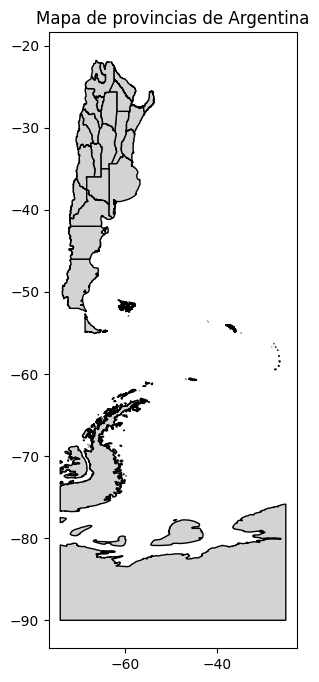

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar provincias desde la API oficial
url_prov = "https://apis.datos.gob.ar/georef/api/v2.0/provincias.geojson"
arg = gpd.read_file(url_prov)

print(arg.head())  # así ves qué columnas trae, debería estar 'nombre' y 'geometry'

# Graficar el mapa de provincias
fig, ax = plt.subplots(figsize=(8, 8))
arg.plot(ax=ax, color="lightgray", edgecolor="black")

plt.title("Mapa de provincias de Argentina")
plt.show()




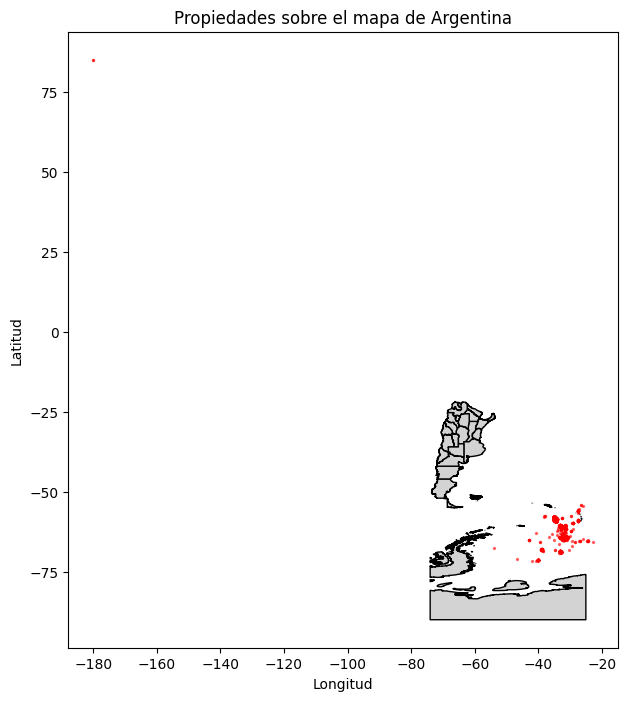

In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1) Cargar provincias (si todavía no lo hiciste)
url_prov = "https://apis.datos.gob.ar/georef/api/v2.0/provincias.geojson"
arg = gpd.read_file(url_prov)
arg = arg.to_crs("EPSG:4326")

# 2) Partir del df_ventas_sin_otros y limpiar coords
df_pts = df_ventas_sin_otros.copy()

# Si hay comas decimales, normalizá (opcional pero común)
for c in ["lat_ok", "lon_ok"]:
    if df_pts[c].dtype == object:
        df_pts[c] = df_pts[c].str.replace(",", ".", regex=False)

df_pts["lat_ok"] = pd.to_numeric(df_pts["lat_ok"], errors="coerce")
df_pts["lon_ok"] = pd.to_numeric(df_pts["lon_ok"], errors="coerce")

# Filtrar solo filas con coordenadas válidas
df_pts = df_pts.dropna(subset=["lat_ok", "lon_ok"]).copy()

# 3) Crear GeoDataFrame usando LAS MISMAS columnas del df_pts
gdf_pts = gpd.GeoDataFrame(
    df_pts,
    geometry=gpd.points_from_xy(df_pts["lon_ok"], df_pts["lat_ok"]),
    crs="EPSG:4326"
)

# 4) Graficar
fig, ax = plt.subplots(figsize=(8, 8))
arg.plot(ax=ax, color="lightgray", edgecolor="black")
gdf_pts.plot(ax=ax, color="red", markersize=2, alpha=0.5)

ax.set_title("Propiedades sobre el mapa de Argentina")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.show()



#### OPCIÓN 2: invertir ambas columnas

In [46]:
# Crear nuevas columnas con valores invertidos
df_ventas_sin_otros["lat_inv"] = df_ventas_sin_otros["lon"]
df_ventas_sin_otros["lon_inv"] = df_ventas_sin_otros["lat"]

##### lat y lon dentro de ARG

In [47]:
# Chequeo de rango Argentina
df_ventas_sin_otros["en_argentina"] = (
    (df_ventas_sin_otros["lat_inv"].between(-56, -22)) & #Máximo Norte (Jujuy): aprox. -22°, Máximo Sur (Tierra del Fuego): aprox. -56°
    (df_ventas_sin_otros["lon_inv"].between(-75, -53)) #Más al Este (Misiones): aprox. -53°, Más al Oeste (Andes, límite con Chile): aprox. -75°
)

# Contar cuántos están dentro y fuera
print("Coordenadas dentro de Argentina:", df_ventas_sin_otros["en_argentina"].sum())
print("Coordenadas fuera de Argentina:", (~df_ventas_sin_otros["en_argentina"]).sum())


Coordenadas dentro de Argentina: 228067
Coordenadas fuera de Argentina: 36198


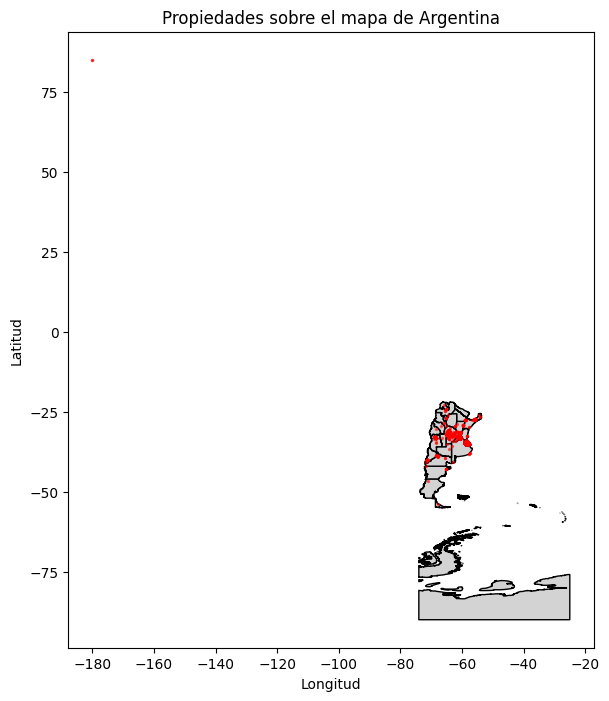

In [48]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1) Cargar provincias (si todavía no lo hiciste)
url_prov = "https://apis.datos.gob.ar/georef/api/v2.0/provincias.geojson"
arg = gpd.read_file(url_prov)
arg = arg.to_crs("EPSG:4326")

# 2) Partir del df_ventas_sin_otros y limpiar coords
df_pts = df_ventas_sin_otros.copy()

# Si hay comas decimales, normalizá (opcional pero común)
for c in ["lat_inv", "lon_inv"]:
    if df_pts[c].dtype == object:
        df_pts[c] = df_pts[c].str.replace(",", ".", regex=False)

df_pts["lat_inv"] = pd.to_numeric(df_pts["lat_inv"], errors="coerce")
df_pts["lon_inv"] = pd.to_numeric(df_pts["lon_inv"], errors="coerce")

# Filtrar solo filas con coordenadas válidas
df_pts = df_pts.dropna(subset=["lat_inv", "lon_inv"]).copy()

# 3) Crear GeoDataFrame usando LAS MISMAS columnas del df_pts
gdf_pts = gpd.GeoDataFrame(
    df_pts,
    geometry=gpd.points_from_xy(df_pts["lon_inv"], df_pts["lat_inv"]),
    crs="EPSG:4326"
)

# 4) Graficar
fig, ax = plt.subplots(figsize=(8, 8))
arg.plot(ax=ax, color="lightgray", edgecolor="black")
gdf_pts.plot(ax=ax, color="red", markersize=2, alpha=0.5)

ax.set_title("Propiedades sobre el mapa de Argentina")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.show()



##### Creo la variable provincia=l2 y reemplazo GBA por Buenos Aires 

In [49]:
# Crear la nueva variable como copia de l2
df_ventas_sin_otros["provincia"] = df_ventas_sin_otros["l2"]

# Reemplazar valores de GBA por "Buenos Aires"
df_ventas_sin_otros["provincia"] = df_ventas_sin_otros["provincia"].replace({
    "Bs.As. G.B.A. Zona Norte": "Buenos Aires",
    "Bs.As. G.B.A. Zona Sur": "Buenos Aires",
    "Bs.As. G.B.A. Zona Oeste": "Buenos Aires"
})

# Reemplazar valores de Capital Federal por "Ciudad Autónoma de Buenos Aires"
df_ventas_sin_otros["provincia"] = df_ventas_sin_otros["provincia"].replace({
    "Capital Federal": "Ciudad Autónoma de Buenos Aires"
})


In [50]:
valores_unicos_provincia = df_ventas_sin_otros['provincia'].unique().tolist()
valores_unicos_provincia

['Ciudad Autónoma de Buenos Aires', 'Buenos Aires', 'Córdoba', 'Santa Fe']

In [51]:
# Rango de coordenadas de CABA (bounding box aproximado)
lat_min, lat_max = -34.71, -34.56
lon_min, lon_max = -58.53, -58.32

# Crear flag True/False
df_ventas_sin_otros["es_caba_bbox"] = (
    (df_ventas_sin_otros["lat_inv"].between(lat_min, lat_max)) &
    (df_ventas_sin_otros["lon_inv"].between(lon_min, lon_max))
)

# Total de filas que dicen ser CABA en la variable provincia
total_prov_caba = (df_ventas_sin_otros["provincia"] == "Ciudad Autónoma de Buenos Aires").sum()

# Total de filas que caen dentro del bounding box
total_bbox_caba = df_ventas_sin_otros["es_caba_bbox"].sum()

# Cruce: casos que coinciden provincia y coordenadas
coinciden = ((df_ventas_sin_otros["provincia"] == "Ciudad Autónoma de Buenos Aires") & df_ventas_sin_otros["es_caba_bbox"]).sum()

print("Casos provincia = CABA:", total_prov_caba)
print("Casos dentro bbox CABA:", total_bbox_caba)
print("Coinciden provincia y bbox:", coinciden)
print("Provincia = CABA pero fuera bbox:", total_prov_caba - coinciden)
print("Dentro bbox pero provincia ≠ CABA:", total_bbox_caba - coinciden)




Casos provincia = CABA: 96234
Casos dentro bbox CABA: 86129
Coinciden provincia y bbox: 80178
Provincia = CABA pero fuera bbox: 16056
Dentro bbox pero provincia ≠ CABA: 5951


In [52]:
# Rango de coordenadas de bs as  (bounding box aproximado)
lat_min, lat_max = -41.0, -33.3
lon_min, lon_max = -63.5, -57.0

# Crear flag True/False
df_ventas_sin_otros["es_bsas_bbox"] = (
    (df_ventas_sin_otros["lat_inv"].between(lat_min, lat_max)) &
    (df_ventas_sin_otros["lon_inv"].between(lon_min, lon_max))
)

# Total de filas que dicen ser bs as en la variable provincia
total_prov_bsas= (df_ventas_sin_otros["provincia"] == "Buenos Aires").sum()

# Total de filas que caen dentro del bounding box
total_bbox_bsas = df_ventas_sin_otros["es_bsas_bbox"].sum()

# Cruce: casos que coinciden provincia y coordenadas
coinciden = ((df_ventas_sin_otros["provincia"] == "Buenos Aires") & df_ventas_sin_otros["es_bsas_bbox"]).sum()

print("Casos provincia = bsas:", total_prov_bsas)
print("Casos dentro bbox bsas:", total_bbox_bsas)
print("Coinciden provincia y bbox:", coinciden)
print("Provincia = bsas pero fuera bbox:", total_prov_bsas - coinciden)
print("Dentro bbox pero provincia ≠ bsas:", total_bbox_bsas - coinciden)

Casos provincia = bsas: 120159
Casos dentro bbox bsas: 187134
Coinciden provincia y bbox: 101092
Provincia = bsas pero fuera bbox: 19067
Dentro bbox pero provincia ≠ bsas: 86042


##### Creo la variable departamento=l3 y reemplazo los barrios de CABA por Ciudad Autónoma de Buenos Aires

In [53]:
# Crear la nueva variable como copia de l3
df_ventas_sin_otros["departamento"] = df_ventas_sin_otros["l3"]

# Si provincia es Capital Federal → forzar el valor
df_ventas_sin_otros.loc[df_ventas_sin_otros["provincia"] == "Capital Federal", "departamento"] = "Ciudad Autónoma de Buenos Aires"


In [55]:
# Crear la nueva variable como copia de l3
df_ventas_sin_otros["departamento"] = df_ventas_sin_otros["l3"]

# Si provincia es Ciudad Autónoma de Buenos Aires → forzar el valor
df_ventas_sin_otros.loc[
    df_ventas_sin_otros["provincia"] == "Ciudad Autónoma de Buenos Aires",
    "departamento"
] = "Ciudad Autónoma de Buenos Aires"


In [56]:
valores_unicos_departamento = df_ventas_sin_otros['departamento'].unique().tolist()
valores_unicos_departamento

['Ciudad Autónoma de Buenos Aires',
 'La Plata',
 nan,
 'Tigre',
 'Córdoba',
 'Lanús',
 'Rosario',
 'Moreno',
 'Quilmes',
 'Ituzaingó',
 'Tres de Febrero',
 'Esteban Echeverría',
 'Morón',
 'Lomas de Zamora',
 'Florencio Varela',
 'Pilar',
 'Avellaneda',
 'La Matanza',
 'San Isidro',
 'Vicente López',
 'Malvinas Argentinas',
 'General San Martín',
 'Berazategui',
 'Escobar',
 'San Miguel',
 'Merlo',
 'Ezeiza',
 'San Fernando',
 'Almirante Brown',
 'Marcos Paz',
 'San Vicente',
 'Presidente Perón',
 'Cañuelas',
 'Hurlingham',
 'José C Paz',
 'General Rodríguez']

##### Creo la variable barrios_caba=l3 y me quedo con los barrios de CABA

In [57]:
# Crear nueva variable 'barrios_caba'
df_ventas_sin_otros["barrios_caba"] = None  # inicializar

# Copiar l3 sólo cuando el departamento es Ciudad Autónoma de Buenos Aires
df_ventas_sin_otros.loc[
    df_ventas_sin_otros["departamento"] == "Ciudad Autónoma de Buenos Aires",
    "barrios_caba"
] = df_ventas_sin_otros["l3"]


In [59]:
df_ventas_sin_otros["barrios_caba"] = df_ventas_sin_otros["barrios_caba"].replace([None], np.nan)
valores_unicos_barrios_caba = df_ventas_sin_otros['barrios_caba'].unique().tolist()
valores_unicos_barrios_caba

['Colegiales',
 'Almagro',
 'Villa Urquiza',
 'San Telmo',
 'Barrio Norte',
 'Villa Devoto',
 'Palermo',
 'Monserrat',
 'Caballito',
 'Balvanera',
 'Villa Ortuzar',
 'Once',
 'Villa Crespo',
 nan,
 'Recoleta',
 'Villa General Mitre',
 'Villa del Parque',
 'Belgrano',
 'Mataderos',
 'Saavedra',
 'Floresta',
 'Flores',
 'Coghlan',
 'Parque Chacabuco',
 'Nuñez',
 'Constitución',
 'Las Cañitas',
 'Villa Riachuelo',
 'Puerto Madero',
 'Paternal',
 'Congreso',
 'Parque Centenario',
 'Parque Patricios',
 'Villa Lugano',
 'San Cristobal',
 'Villa Real',
 'San Nicolás',
 'Boca',
 'Versalles',
 'Villa Luro',
 'Chacarita',
 'Retiro',
 'Barracas',
 'Boedo',
 'Monte Castro',
 'Villa Pueyrredón',
 'Liniers',
 'Abasto',
 'Velez Sarsfield',
 'Tribunales',
 'Pompeya',
 'Centro / Microcentro',
 'Parque Avellaneda',
 'Villa Santa Rita',
 'Agronomía',
 'Parque Chas',
 'Catalinas',
 'Villa Soldati']

In [60]:
df_ventas_sin_otros["barrios_caba"] = df_ventas_sin_otros["barrios_caba"].replace("Boca", "La Boca")

#### Chequeo de NA en barrios porteños

In [63]:
mask = (
    (df_ventas_sin_otros["departamento"] == "Ciudad Autónoma de Buenos Aires")
    & (df_ventas_sin_otros["barrios_caba"].isna())
)

# Cantidad de casos
na_en_caba = mask.sum()
print("Cantidad de NA en barrios_caba cuando departamento es CABA:", na_en_caba)


Cantidad de NA en barrios_caba cuando departamento es CABA: 5816


##### OPCIONES:
1) Ver si tienen lat y lon y si tienen sentido dentro de CABA. Si tienen imputar esos valores a lat_real y lon_real
2) Usar NLP en title y description para averiguar el barrio

###### 1

In [64]:
mask = (
    (df_ventas_sin_otros["departamento"] == "Ciudad Autónoma de Buenos Aires")
    & (df_ventas_sin_otros["barrios_caba"].isna())
)

# Casos que cumplen el mask y además tienen lat/lon no nulos
mask_con_coords = mask & df_ventas_sin_otros["lat_ok"].notna() & df_ventas_sin_otros["lon_ok"].notna()

cantidad_con_coords = mask_con_coords.sum()

print("Cantidad de NA en barrios_caba (CABA) con coordenadas válidas:", cantidad_con_coords)


Cantidad de NA en barrios_caba (CABA) con coordenadas válidas: 1442


Hay 1.442 casos de los 5.816 que tienen lat y lon

In [65]:
lat_min, lat_max = -34.71, -34.56
lon_min, lon_max = -58.53, -58.32

mask = (
    (df_ventas_sin_otros["departamento"] == "Ciudad Autónoma de Buenos Aires")
    & (df_ventas_sin_otros["barrios_caba"].isna())
    & df_ventas_sin_otros["lat_ok"].notna()
    & df_ventas_sin_otros["lon_ok"].notna()
)

# Dentro del bounding box
mask_caba_bbox = (
    mask
    & df_ventas_sin_otros["lat_ok"].between(lat_min, lat_max)
    & df_ventas_sin_otros["lon_ok"].between(lon_min, lon_max)
)

print("Casos con coords en CABA (bounding box):", mask_caba_bbox.sum())
print("Total con coords pero NA en barrios_caba:", mask.sum())


Casos con coords en CABA (bounding box): 0
Total con coords pero NA en barrios_caba: 1442


Peeeero ninguno de los casos está dentro de CABA 🙃

###### CONCLUSIONES:
No sé si vale la pena seguir por este camino. Voy a probar la opción 2

###### 2

#### Límites a mano
Hay barrios que no son oficiales, pero sí se conocen las zonas.

In [61]:
# Límites
coords = {
    "Barrio Norte": {"lat_real": -34.591667, "lon_real": -58.401111}, #Fuente: Wikipedia
    "Las Cañitas": {"lat_real": -34.57, "lon_real": -58.429722}, #Fuente: Wikipedia
    "Parque Centenario": {"lat_real": -34.60599321318619, "lon_real": -58.435360262260495}, #Fuente: Google Maps
    "Tribunales":{"lat_real":-34.60100369194255,"lon_real": -58.384581772040654},#Fuente: Google Maps, centro plaza lavalle
    "Centro / Microcentro":{"lat_real": -34.603889, "lon_real": -58.370556}, #Fuente: Wikipedia
    "Catalinas":{"lat_real": -34.59624770032785, "lon_real": -58.370631086419046}, #Fuente: Google Maps, estación de subte
    "Abasto":{"lat_real": -34.603611, "lon_real": -58.410833}, #Fuente: Wikipedia
    "Congreso":{"lat_real": -34.609068468581015, "lon_real": -58.39262853144608}, #Fuente: Google Maps
    }

In [ ]:
#import pandas as pd
#import geopandas as gpd
#from shapely.geometry import Point
#from unidecode import unidecode
#
## ----------------------------
## 1) Helpers
## ----------------------------
#def norm(x):
#    """Normaliza texto para comparar nombres (sin tildes, casefold, strip)."""
#    if pd.isna(x): 
#        return None
#    return unidecode(str(x)).strip().casefold()
#
#def pick_name_column(gdf, candidates):
#    """Intenta elegir la columna de nombre más razonable dentro de candidatos."""
#    cols = {c.lower(): c for c in gdf.columns}
#    for cand in candidates:
#        if cand.lower() in cols:
#            return cols[cand.lower()]
#    # fallback: busca algo que contenga "nombre" o "name"
#    for c in gdf.columns:
#        if "nombre" in c.lower() or "name" in c.lower():
#            return c
#    # último recurso: primera columna de objeto/string
#    for c in gdf.columns:
#        if gdf[c].dtype == 'object':
#            return c
#    return gdf.columns[0]
#
## ----------------------------
## 2) Tu DataFrame con lat_ok / lon_ok y variables l2/l3 ya trabajadas
##    Supongamos:
##    - df tiene columnas: lat_ok, lon_ok, provincia (de l2 unificada), departamento (de l3 o "CABA")
## ----------------------------
## df = ...
#
## Filtramos filas válidas
#df_valid = df_ventas_sin_otros.dropna(subset=["lat_ok", "lon_ok"]).copy()
#
## GeoDataFrame de puntos (EPSG:4326 = WGS84)
#gdf_pts = gpd.GeoDataFrame(
#    df_valid,
#    geometry=gpd.points_from_xy(df_valid["lon_ok"], df_valid["lat_ok"]),
#    crs="EPSG:4326"
#)
#
## ----------------------------
## 3) Cargar capas oficiales (GeoJSON desde URL)
## ----------------------------
#url_prov = "https://apis.datos.gob.ar/georef/api/v2.0/provincias.geojson"
#url_depto = "https://infra.datos.gob.ar/georef-dev/departamentos.geojson"
#url_barrios_caba = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/innovacion-transformacion-digital/barrios/barrios.geojson"
#
#gdf_prov = gpd.read_file(url_prov)
#gdf_depto = gpd.read_file(url_depto)
#gdf_barrios = gpd.read_file(url_barrios_caba)
#
## Asegurar mismo CRS
#for g in (gdf_prov, gdf_depto, gdf_barrios):
#    if g.crs is None:
#        g.set_crs("EPSG:4326", inplace=True)
#    elif g.crs.to_string() != "EPSG:4326":
#        g.to_crs("EPSG:4326", inplace=True)
#
## Elegimos columnas de nombre
#prov_name_col  = pick_name_column(gdf_prov,  ["nombre", "provincia", "provincia_nombre"])
#depto_name_col = pick_name_column(gdf_depto, ["nombre", "departamento", "departamento_nombre"])
#barrio_name_col= pick_name_column(gdf_barrios,["barrio","nombre","name"])
#
## ----------------------------
## 4) Spatial join: Provincias
##    Usamos predicate='within' (si un punto cae EXACTO en frontera, within puede fallar.
##    Si querés robustez extra, repetimos con 'intersects' para los faltantes)
## ----------------------------
#pts_prov = gpd.sjoin(gdf_pts, gdf_prov[[prov_name_col, "geometry"]], how="left", predicate="within")
## Completar faltantes por frontera con intersects:
#mask_no_prov = pts_prov[prov_name_col].isna()
#if mask_no_prov.any():
#    pts_prov2 = gpd.sjoin(gdf_pts.loc[mask_no_prov], gdf_prov[[prov_name_col,"geometry"]], how="left", predicate="intersects")
#    pts_prov.loc[mask_no_prov, prov_name_col] = pts_prov2[prov_name_col]
#
#pts_prov = pts_prov.rename(columns={prov_name_col:"prov_nombre_georef"})
#
## ----------------------------
## 5) Spatial join: Departamentos
## ----------------------------
#pts_depto = gpd.sjoin(pts_prov, gdf_depto[[depto_name_col, "geometry"]], how="left", predicate="within")
#mask_no_depto = pts_depto[depto_name_col].isna()
#if mask_no_depto.any():
#    pts_depto2 = gpd.sjoin(pts_prov.loc[mask_no_depto], gdf_depto[[depto_name_col,"geometry"]], how="left", predicate="intersects")
#    pts_depto.loc[mask_no_depto, depto_name_col] = pts_depto2[depto_name_col]
#
#pts_depto = pts_depto.rename(columns={depto_name_col:"depto_nombre_georef"})
#
## ----------------------------
## 6) Caso especial CABA: si departamento == "Ciudad Autónoma de Buenos Aires"
##    chequear barrio y setear un campo auxiliar
## ----------------------------
#es_caba = pts_depto["departamento"].apply(lambda x: norm(x) == norm("Ciudad Autónoma de Buenos Aires"))
#gdf_caba = pts_depto.copy()
#
## Inicializamos columna de barrio encontrada
#gdf_caba["barrio_caba_georef"] = pd.NA
#
#if es_caba.any():
#    pts_caba = gdf_caba.loc[es_caba]
#    join_caba = gpd.sjoin(pts_caba, gdf_barrios[[barrio_name_col,"geometry"]], how="left", predicate="within")
#    join_caba = join_caba.rename(columns={barrio_name_col:"barrio_caba_georef"})
#    # Volcamos lo encontrado de vuelta
#    gdf_caba.loc[es_caba, "barrio_caba_georef"] = join_caba["barrio_caba_georef"].values
#
## ----------------------------
## 7) Flags de coincidencia (comparación por nombre normalizado)
## ----------------------------
#gdf_caba["prov_ok"] = (gdf_caba["provincia"].apply(norm) == gdf_caba["prov_nombre_georef"].apply(norm))
#
## Para departamentos, comparamos contra l3 normalizado (ya copiado en "departamento")
#gdf_caba["depto_ok"] = (gdf_caba["departamento"].apply(norm) == gdf_caba["depto_nombre_georef"].apply(norm))
#
## Si es CABA, depto_ok debería ser True justamente cuando el georef devuelve "Ciudad Autónoma de Buenos Aires"
## (Depende del nombre que venga en el GeoJSON de departamentos; si no coincide, forzamos la lógica CABA)
#gdf_caba.loc[es_caba, "depto_ok"] = True  # porque para CABA validás con barrios, no contra deptos
#
## Flag general
#gdf_caba["coord_ok_georef"] = gdf_caba["prov_ok"] & gdf_caba["depto_ok"]
#
## ----------------------------
## 8) Resumen
## ----------------------------
#resumen = {
#    "total_puntos": len(gdf_caba),
#    "coinciden_provincia": int(gdf_caba["prov_ok"].sum()),
#    "coinciden_departamento": int(gdf_caba["depto_ok"].sum()),
#    "coordenadas_ok_en_georef": int(gdf_caba["coord_ok_georef"].sum()),
#    "caba_registros": int(es_caba.sum()),
#    "caba_con_barrio_asignado": int(gdf_caba.loc[es_caba, "barrio_caba_georef"].notna().sum()),
#}
#print(resumen)
#
## Si querés volcar columnas útiles de vuelta a tu df original:
#cols_utiles = ["prov_nombre_georef","depto_nombre_georef","barrio_caba_georef","prov_ok","depto_ok","coord_ok_georef"]
#df_out = pd.DataFrame(gdf_caba.drop(columns="geometry"))  # quitar geometría para devolver a pandas
#df_out = df_out[df_out.columns.intersection(df.columns.tolist() + cols_utiles)]


ValueError: 'index_right' cannot be a column name in the frames being joined

In [44]:
import geopandas as gpd
import pandas as pd
from shapely.validation import make_valid

# ------- 0) Sanidad básica de tus puntos (asegurate de usar lat_ok/lon_ok) -------
assert "lat_ok" in df_ventas_sin_otros.columns and "lon_ok" in df_ventas_sin_otros.columns, "Faltan lat_ok / lon_ok"

gdf_pts = gpd.GeoDataFrame(
    df_ventas_sin_otros.dropna(subset=["lat_ok","lon_ok"]).copy(),
    geometry=gpd.points_from_xy(df_ventas_sin_otros.dropna(subset=["lat_ok","lon_ok"])["lon_ok"],
                                df_ventas_sin_otros.dropna(subset=["lat_ok","lon_ok"])["lat_ok"]),
    crs="EPSG:4326"
)

print("Puntos:", len(gdf_pts))
print("CRS puntos:", gdf_pts.crs)
assert not gdf_pts.empty, "gdf_pts está vacío"

# ------- 1) Cargar Departamentos y normalizar CRS / geometrías -------
url_depto = "https://infra.datos.gob.ar/georef-dev/departamentos.geojson"
gdf_depto = gpd.read_file(url_depto)

# Asegurar CRS
if gdf_depto.crs is None:
    gdf_depto.set_crs("EPSG:4326", inplace=True)
elif gdf_depto.crs.to_string() != "EPSG:4326":
    gdf_depto = gdf_depto.to_crs("EPSG:4326")

print("CRS depto:", gdf_depto.crs)
assert gdf_pts.crs == gdf_depto.crs, "CRS distintos entre puntos y deptos"

# Asegurar que haya geometry y no esté vacío
assert "geometry" in gdf_depto.columns, "gdf_depto no tiene geometry"
assert not gdf_depto.empty, "gdf_depto está vacío"

# Columna de nombre (ajusta si en tu archivo el campo se llama distinto)
name_candidates = [c for c in gdf_depto.columns if c.lower() in ("nombre","departamento","name","nom_dep","nam")]
depto_name_col = name_candidates[0] if name_candidates else "nombre"

# Fix de geometrías inválidas (muy común)
gdf_depto["geometry"] = gdf_depto.geometry.apply(make_valid)

# (Opcional) Explode multipolígonos
gdf_depto = gdf_depto.explode(index_parts=False, ignore_index=True)

# Resetear índices para evitar problemas raros en sjoin
gdf_pts = gdf_pts.reset_index(drop=True)
gdf_depto = gdf_depto.reset_index(drop=True)

# ------- 2) Spatial join robusto -------
# Preferimos 'contains' (polígono contiene punto). Si cae en borde, reintentamos con 'intersects'.
pts_depto = gpd.sjoin(
    gdf_pts, 
    gdf_depto[[depto_name_col, "geometry"]],
    how="left",
    predicate="contains"
)

# Reintento para los NaN (puntos en frontera)
mask_nan = pts_depto[depto_name_col].isna()
if mask_nan.any():
    retry = gpd.sjoin(
        gdf_pts.loc[mask_nan],
        gdf_depto[[depto_name_col, "geometry"]],
        how="left",
        predicate="intersects"
    )
    pts_depto.loc[mask_nan, depto_name_col] = retry[depto_name_col].values

# Renombrar y revisar resultado
pts_depto = pts_depto.rename(columns={depto_name_col: "depto_nombre_georef"})
print("Filas tras join deptos:", len(pts_depto))
print("Sin match de depto:", pts_depto["depto_nombre_georef"].isna().sum())


Puntos: 228069
CRS puntos: EPSG:4326
CRS depto: EPSG:4326
Filas tras join deptos: 228069
Sin match de depto: 228069


## Datos de propiedad

### Superficie cubierta y superficie total

### Baños

### Dormitorios

In [72]:
p99_bedrooms = df_ventas_sin_otros["bedrooms"].quantile(0.99)
print("Percentil 99 de bedrooms:", p99_bedrooms)

Percentil 99 de bedrooms: 5.0


#### Observaciones:
- Hay valores negativos
- El percentil 95 es de 4 dormitorios y el percentil 99 es 5 dormitorios
- Missing 86.344 casos

#### Acciones:
- Opción 1: Imputar en base a el título y descripción tanto los valores extremos como los NA (antes de CV y modelado)
- Opción 2: Imputar en base a el título y descripción sólo a los valores extremos (antes de CV y modelado)
- Opción 3: Imputar en base a el título y descripción sólo a los valores extremos (antes de CV y modelado) e imputar los NA con MICE (dentro de los folds)
- Opción 4: Convertir en NA esos casos y utilizar método de imputación MICE sobre todos los NA(dentro de cada fold)


### Habitaciones

# Creación de variables usando NLP

## Superficie total
Busca dos tipos de patrones: si dice la superficie total en el título o descripción o si la publicación indica el tamaño del lote

In [ ]:
def extraer_superficie_total_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue

        # --- 1) Buscar expresiones tipo "superficie total: 300" ---
        patron1 = r"(sup(?:erficie)?\.?\s*total(?:\s*por\s*escritura)?[:\s-]*)(\d+[.,]?\d*)"
        coincidencia1 = re.search(patron1, texto, re.IGNORECASE)
        if coincidencia1:
            valor = coincidencia1.group(2).replace(',', '.')
            try:
                return float(valor)
            except:
                return None

        # --- 2) Buscar medidas tipo "10x30" o "10 x 30" ---
        patron2 = r"(\d+[.,]?\d*)\s*[xX]\s*(\d+[.,]?\d*)"
        coincidencia2 = re.search(patron2, texto, re.IGNORECASE)
        if coincidencia2:
            try:
                ancho = float(coincidencia2.group(1).replace(',', '.'))
                largo = float(coincidencia2.group(2).replace(',', '.'))
                return ancho * largo
            except:
                return None

    return None

# Aplicar al DataFrame
df_ventas_sin_otros['superficie_total_nlp'] = df_ventas_sin_otros.apply(extraer_superficie_total_desde_filas, axis=1)


## Superficie cubierta

In [24]:
def extraer_superficie_cubierta_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue
        patron = r"(sup(?:erficie)?\.?\s*cub(?:ierta)?(?:\s*por\s*escritura)?[:\s-]*|sup\.?\s*cub\.?[:\s-]*)(\d+[.,]?\d*)"
        coincidencia = re.search(patron, texto, re.IGNORECASE)
        if coincidencia:
            valor = coincidencia.group(2).replace(',', '.')
            try:
                return float(valor)
            except:
                return None
    return None

df_ventas_sin_otros['superficie_cubierta_nlp'] = df_ventas_sin_otros.apply(extraer_superficie_cubierta_desde_filas, axis=1)

## Cantidad de ambientes

In [25]:
def extraer_ambientes_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue
        # Busca patrones como "X ambientes", "X amb.", "X amb", "X ambientes amplios", etc.
        patron = r"(\d+)[\s\-]*(ambientes|amb\.?|ambiente)"
        coincidencia = re.search(patron, texto, re.IGNORECASE)
        if coincidencia:
            try:
                return float(coincidencia.group(1))
            except:
                return None
    return None

df_ventas_sin_otros['ambientes_nlp'] = df_ventas_sin_otros.apply(extraer_ambientes_desde_filas, axis=1)

## Cantidad de baños

In [26]:
def extraer_banos_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue
        # Busca patrones como "X baños", "X baño", "X baños completos", etc.
        patron = r"(\d+)[\s\-]*(baños|baño)"
        coincidencia = re.search(patron, texto, re.IGNORECASE)
        if coincidencia:
            try:
                return float(coincidencia.group(1))
            except:
                return None
    return None

df_ventas_sin_otros['banos_nlp'] = df_ventas_sin_otros.apply(extraer_banos_desde_filas, axis=1)

In [ ]:
import re
import pandas as pd
from unidecode import unidecode

TEXT2NUM_ES = {
    "un":1, "uno":1, "una":1, "dos":2, "tres":3, "cuatro":4, "cinco":5,
    "seis":6, "siete":7, "ocho":8, "nueve":9, "diez":10
}

def norm_text(s):
    if pd.isna(s):
        return ""
    return re.sub(r"\s+", " ", unidecode(str(s)).lower()).strip()

def es_monoambiente(text):
    return bool(re.search(r"\bmonoambiente\b", text))

def extraer_banos_y_toilettes(row):
    textos = [norm_text(t) for t in [row.get("description"), row.get("title")] if t is not None]
    banos = None
    toilettes = None

    for t in textos:
        # baños completos
        for m in re.finditer(r"\b(\d+)\s*ban(?:o|os)\b", t):
            val = int(m.group(1))
            banos = max(banos or 0, val)
        for m in re.finditer(r"\b(un|uno|una|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez)\s*ban(?:o|os)\b", t):
            val = TEXT2NUM_ES[m.group(1)]
            banos = max(banos or 0, val)

        # toilettes
        for m in re.finditer(r"\b(\d+)\s*(?:toilettes?|toilet|toil)\b", t):
            val = int(m.group(1))
            toilettes = (toilettes or 0) + val
        for m in re.finditer(r"\b(un|uno|una|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez)\s*(?:toilettes?|toilet|toil)\b", t):
            val = TEXT2NUM_ES[m.group(1)]
            toilettes = (toilettes or 0) + val

    # si es monoambiente y no se encontró nada → 1 baño
    if any(es_monoambiente(t) for t in textos) and banos is None and toilettes is None:
        banos, toilettes = 1, 0

    return pd.Series({"banos_nlp": banos, "toilettes_nlp": toilettes})

# aplicar al dataframe
df_ventas_sin_otros[["banos_nlp", "toilettes_nlp"]] = df_ventas_sin_otros.apply(extraer_banos_y_toilettes, axis=1)


## Cantidad de dormitorios

In [66]:
import re
import pandas as pd
from unidecode import unidecode

# Mapeo de números en palabras → enteros
TEXT2NUM_ES = {
    "un":1, "uno":1, "una":1, "dos":2, "tres":3, "cuatro":4, "cinco":5,
    "seis":6, "siete":7, "ocho":8, "nueve":9, "diez":10
}

# Palabras que indican plantas/pisos para sumar dormitorios por segmento
PLANTA_PALABRAS = r"(?:pb|pa|planta\s*baja|planta\s*alta|primer\s*piso|1er\s*piso|segundo\s*piso|2do\s*piso|tercer\s*piso|3er\s*piso)"

def norm_text(s):
    if pd.isna(s):
        return ""
    return re.sub(r"\s+", " ", unidecode(str(s)).lower()).strip()

def detect_ambientes(text):
    # monoambiente
    if re.search(r"\bmonoambiente\b", text):
        return 0
    # N ambientes (2 ambientes, 3 ambientes, etc.)
    m = re.search(r"\b(\d+)\s*ambiente(?:s)?\b", text)
    if m:
        n = int(m.group(1))
        return max(n - 1, 0)
    # números escritos + ambientes (dos ambientes, tres ambientes…)
    m2 = re.search(r"\b(un|uno|una|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez)\s*ambiente(?:s)?\b", text)
    if m2:
        n = TEXT2NUM_ES[m2.group(1)]
        return max(n - 1, 0)
    return None

def detect_dormitorios_explicitos(text):
    candidatos = []

    # 1) Dígitos + dormitorios/habitaciones
    for m in re.finditer(r"\b(\d+)\s*(?:dorm(?:itorio)?s?|habitaciones?)\b", text):
        candidatos.append(int(m.group(1)))

    # 2) Palabras + dormitorios/habitaciones (un/uno/dos/tres…)
    for m in re.finditer(r"\b(un|uno|una|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez)\s*(?:dorm(?:itorio)?s?|habitaciones?)\b", text):
        candidatos.append(TEXT2NUM_ES[m.group(1)])

    # 3) “principal + segundo dormitorio” (mínimo 2 si aparecen ordinales)
    if re.search(r"\bsegund[oa]\s+dormitorio\b", text) and not candidatos:
        candidatos.append(2)

    return max(candidatos) if candidatos else None

def detect_dormitorios_por_planta(text):
    total = 0
    hallazgo = False

    # Patrones tipo: "1 dormitorio en PB", "2 en PA", "un dormitorio en primer piso"
    patron1 = rf"\b(\d+)\s*(?:dorm(?:itorio)?s?)?\s*en\s*{PLANTA_PALABRAS}\b"
    for m in re.finditer(patron1, text):
        total += int(m.group(1)); hallazgo = True

    patron2 = rf"\b(un|uno|una|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez)\s*(?:dorm(?:itorio)?s?)?\s*en\s*{PLANTA_PALABRAS}\b"
    for m in re.finditer(patron2, text):
        total += TEXT2NUM_ES[m.group(1)]; hallazgo = True

    # Patrón explícito con la palabra dormitorio incluida: "2 dormitorios en planta alta", etc.
    patron3 = rf"\b(\d+)\s*dorm(?:itorio)?s?\s*en\s*{PLANTA_PALABRAS}\b"
    for m in re.finditer(patron3, text):
        total += int(m.group(1)); hallazgo = True

    patron4 = rf"\b(un|uno|una|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez)\s*dorm(?:itorio)?s?\s*en\s*{PLANTA_PALABRAS}\b"
    for m in re.finditer(patron4, text):
        total += TEXT2NUM_ES[m.group(1)]; hallazgo = True

    return total if hallazgo else None

def extract_bedrooms_from_text(text_raw):
    text = norm_text(text_raw)

    # A) Señales por ambientes
    amb = detect_ambientes(text)
    # B) Total explícito
    exp_total = detect_dormitorios_explicitos(text)
    # C) Suma por planta/piso
    por_planta = detect_dormitorios_por_planta(text)

    candidatos = [v for v in [exp_total, por_planta, amb] if v is not None]
    if not candidatos:
        return None

    # Regla de prioridad: si hay “explícito” y “por planta”, devolver el mayor.
    # Si sólo hay ambientes, devolver ese (como estimación).
    return max(candidatos)

def extract_bedrooms_row(row):
    # Evaluar en title y description y quedarnos con el mayor (más informativo)
    vals = []
    for col in ("title", "description"):
        vals.append(extract_bedrooms_from_text(row.get(col, None)))
    vals = [v for v in vals if v is not None]
    return max(vals) if vals else None

# Aplicar al DataFrame
df_ventas_sin_otros["bedrooms_nlp"] = df_ventas_sin_otros.apply(extract_bedrooms_row, axis=1)


## Flag más de una propiedad

In [ ]:
def flag_multipropiedad(row):
    patrones = [
        r"(\bvarias\b|\bvarios\b|\bmúltiples\b|\bmultiple\b|\bmultiplas\b)",  # varias/varios/múltiples
        r"(\bconjunto\b|\bconjuntos\b)",  # conjunto de propiedades
        r"(\bideal\b.*\bconstructor\b)",  # ideal constructor
        r"(\bideal\b.*\bemprendimiento\b)",  # ideal emprendimiento
        r"(\bterrenos\b|\blotes\b|\bgalpones\b|\bdepartamentos\b|\bcasas\b|\bphs\b)",  # plural de tipos
        r"(\bse venden\b|\bse alquilan\b|\bventa en block\b|\ben block\b)",  # block
        r"(\bmanzana\b.*\bcompleta\b)",  # manzana completa
        r"(\bfracciones\b|\bfraccion\b)",  # fracciones
        r"(\bph\b.*\bcon\b.*\bdepartamentos\b)",  # ph con departamentos
        r"(\b2\b.*\bpropiedades\b|\b2\b.*\bcasas\b|\b2\b.*\bdepartamentos\b)",  # 2 propiedades/casas/departamentos
        r"(\b3\b.*\bpropiedades\b|\b3\b.*\bcasas\b|\b3\b.*\bdepartamentos\b)",  # 3 propiedades/casas/departamentos
        r"(\b4\b.*\bpropiedades\b|\b4\b.*\bcasas\b|\b4\b.*\bdepartamentos\b)",  # 4 propiedades/casas/departamentos
        r"(\b5\b.*\bpropiedades\b|\b5\b.*\bcasas\b|\b5\b.*\bdepartamentos\b)",  # 5 propiedades/casas/departamentos
        r"(\b6\b.*\bpropiedades\b|\b6\b.*\bcasas\b|\b6\b.*\bdepartamentos\b)",  # 6 propiedades/casas/departamentos
        r"(\b7\b.*\bpropiedades\b|\b7\b.*\bcasas\b|\b7\b.*\bdepartamentos\b)",  # 7 propiedades/casas/departamentos
        r"(\b8\b.*\bpropiedades\b|\b8\b.*\bcasas\b|\b8\b.*\bdepartamentos\b)",  # 8 propiedades/casas/departamentos
        r"(\b9\b.*\bpropiedades\b|\b9\b.*\bcasas\b|\b9\b.*\bdepartamentos\b)",  # 9 propiedades/casas/departamentos
        r"(\b10\b.*\bpropiedades\b|\b10\b.*\bcasas\b|\b10\b.*\bdepartamentos\b)",  # 10 propiedades/casas/departamentos
    ]
    texto = f"{row['description']} {row['title']}".lower() if pd.notnull(row['description']) or pd.notnull(row['title']) else ""
    for patron in patrones:
        if re.search(patron, texto):
            return 1
    return 0

df_ventas_sin_otros['flag_multipropiedad'] = df_ventas_sin_otros.apply(flag_multipropiedad, axis=1)

# Chequeos

## lat y lon
Errores en localidad: 289254

In [53]:
# --- Opción A COMPLETA: validar l3 contra localidades del IGN (solo localidad) ---

import geopandas as gpd
import pandas as pd
import numpy as np
import unicodedata
from shapely.geometry import Point

# ---------- helpers ----------
def norm(x):
    if pd.isna(x): 
        return None
    x = str(x).strip().lower()
    # quitar acentos
    x = ''.join(c for c in unicodedata.normalize('NFD', x)
                if unicodedata.category(c) != 'Mn')
    return x

# ---------- 1) GeoDataFrame con tus propiedades en EPSG:4326 ----------
gdf = gpd.GeoDataFrame(
    df_ventas_sin_otros.copy(),
    geometry=gpd.points_from_xy(df_ventas_sin_otros.lon, df_ventas_sin_otros.lat),
    crs="EPSG:4326"
)

# (opcional) corregir lat/lon invertidas antes del join
lat_ok = gdf.geometry.y.between(-56, -22)
lon_ok = gdf.geometry.x.between(-75, -53)
mask_swap = (~lat_ok) & (~lon_ok) & gdf.geometry.y.between(-75, -53) & gdf.geometry.x.between(-56, -22)
if mask_swap.any():
    gdf.loc[mask_swap, "geometry"] = [
        Point(y, x) for x, y in zip(gdf.loc[mask_swap, "geometry"].x,
                                    gdf.loc[mask_swap, "geometry"].y)
    ]

# ---------- 2) Cargar LOCALIDADES (puntos) del IGN (solo nombre y geometría) ----------
url_loc = "https://infra.datos.gob.ar/georef-dev/localidades.geojson"
localidades = gpd.read_file(url_loc)[["nombre", "geometry"]].copy()
localidades["loc_n"] = localidades["nombre"].apply(norm)

# ---------- 3) PROYECTAR A METROS y hacer sjoin_nearest con distancia en metros ----------
gdf_m  = gdf.to_crs(3857)
loc_m  = localidades.to_crs(3857)

# Join por vecino más cercano (distancia queda en 'dist_m' directamente en metros)
gdf_loc_m = gpd.sjoin_nearest(gdf_m, loc_m, how="left", distance_col="dist_m")

# ---------- 4) Comparar nombres normalizados (l3 vs IGN) ----------
# (tomamos 'nombre' y 'loc_n' que vinieron del right join)
gdf_loc_m["l3_n"]  = gdf_loc_m["l3"].apply(norm)
gdf_loc_m["coincide_loc_nombre"] = (gdf_loc_m["l3_n"] == gdf_loc_m["loc_n"])

# ---------- 5) Umbral de distancia y flag final ----------
UMBRAL_M = 25_000  # 25 km (ajustá: AMBA 5–10 km; interior 25–50 km)
gdf_loc_m["dentro_umbral"] = gdf_loc_m["dist_m"] <= UMBRAL_M

# Coincide si el nombre matchea y la distancia es razonable
gdf_loc_m["coincide_loc"] = gdf_loc_m["coincide_loc_nombre"] & gdf_loc_m["dentro_umbral"]

# ---------- 6) Métricas ----------
total = len(gdf_loc_m)
sin_match = gdf_loc_m["loc_n"].isna().sum()
errores_nombre = (~gdf_loc_m["coincide_loc_nombre"]).sum()
lejos = (~gdf_loc_m["dentro_umbral"]).sum()
errores_final = (~gdf_loc_m["coincide_loc"]).sum()

print(f"Total registros: {total}")
print(f"Sin localidad asignada (NaN): {sin_match}")
print(f"No coinciden por nombre (l3 vs IGN): {errores_nombre}")
print(f"Fuera de umbral de distancia ({UMBRAL_M/1000:.0f} km): {lejos}")
print(f"Errores finales (nombre no coincide o muy lejos): {errores_final}")

# ---------- 7) Resumen por l3 declarada ----------
resumen = (gdf_loc_m
           .assign(l3_show=gdf_loc_m["l3"].fillna("desconocida"))
           .groupby("l3_show")
           .agg(total=("l3_show", "size"),
                no_coinciden=("coincide_loc", lambda s: (~s).sum()))
           .sort_values("no_coinciden", ascending=False))
print(resumen.head(20))

# ---------- 8) Muestra de casos problemáticos ----------
cols_err = [c for c in ["l3", "nombre", "dist_m", "coincide_loc_nombre", "dentro_umbral"] if c in gdf_loc_m.columns]
muestra_errores = gdf_loc_m.loc[~gdf_loc_m["coincide_loc"], cols_err].head(20)
print(muestra_errores)


Total registros: 289254
Sin localidad asignada (NaN): 38430
No coinciden por nombre (l3 vs IGN): 199257
Fuera de umbral de distancia (25 km): 38476
Errores finales (nombre no coincide o muy lejos): 199257
                 total  no_coinciden
l3_show                             
Tigre            16709         14143
desconocida      10619         10619
Rosario          35871         10340
Almagro           8074          8074
Villa Crespo      7542          7542
Belgrano          7513          7513
La Matanza        6965          6638
Lomas de Zamora  11582          6497
Caballito         6301          6301
Pilar             7691          6256
La Plata         10200          6255
Escobar           5303          5152
San Isidro        5695          4984
Recoleta          4749          4749
Morón             6481          3987
Tres de Febrero   4532          3862
Vicente López     5249          3753
Lanús             4838          3610
Ituzaingó         4038          3536
Quilmes           

In [46]:
df_ventas_sin_otros.head(1)

,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,title,description,property_type,operation_type,price,superficie_total_nlp,superficie_cubierta_nlp,ambientes_nlp,banos_nlp,flag_multipropiedad
0,556713,2019-11-29,NaT,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,NaN,...,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0,96.47,NaN,4.0,NaN,0


Errores en provincia

In [ ]:
import geopandas as gpd
import pandas as pd
import unicodedata
import numpy as np

# ---- helpers ----
def norm(x):
    if pd.isna(x): return None
    x = str(x).strip().lower()
    x = ''.join(c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn')
    return x

# equivalencias comunes (podés sumar más)
ALIASES = {
    "caba": "ciudad autonoma de buenos aires",
    "capital federal": "ciudad autonoma de buenos aires",
    "buenos aires (caba)": "ciudad autonoma de buenos aires",
    "bs as": "buenos aires",
}

def map_alias(x):
    if x is None: return None
    return ALIASES.get(x, x)

# ---- 1) GeoDataFrame de tus propiedades ----
gdf = gpd.GeoDataFrame(
    df_ventas_sin_otros.copy(),
    geometry=gpd.points_from_xy(df_ventas_sin_otros.lon, df_ventas_sin_otros.lat),
    crs="EPSG:4326"
)

# (opcional) detectar lat/lon invertidas y corregir automáticamente
lat_ok = gdf["geometry"].y.between(-56, -22)
lon_ok = gdf["geometry"].x.between(-75, -53)
mask_swap = (~lat_ok) & (~lon_ok) & gdf["geometry"].y.between(-75, -53) & gdf["geometry"].x.between(-56, -22)
gdf.loc[mask_swap, "geometry"] = gpd.points_from_xy(gdf.loc[mask_swap, "geometry"].y,
                                                    gdf.loc[mask_swap, "geometry"].x, crs="EPSG:4326")

# ---- 2) Provincias (polígonos) desde API oficial ----
url_prov = "https://apis.datos.gob.ar/georef/api/v2.0/provincias.geojson"
provincias = gpd.read_file(url_prov)[["nombre", "geometry"]]

# normalizar nombre de provincia del shapefile
provincias["prov_n"] = provincias["nombre"].apply(norm).apply(map_alias)

# ---- 3) Spatial join: punto dentro de polígono de provincia ----
gdf_p = gpd.sjoin(gdf, provincias[["prov_n", "geometry"]], how="left", predicate="within")

# ---- 4) Normalizar l2 y comparar ----
gdf_p["l2_n"] = gdf_p["l2"].apply(norm).apply(map_alias)
gdf_p["fuera_arg"] = gdf_p["prov_n"].isna()
gdf_p["coincide_prov"] = (~gdf_p["fuera_arg"]) & (gdf_p["l2_n"] == gdf_p["prov_n"])

# ---- 5) Métricas básicas ----
total = len(gdf_p)
errores_fuera = gdf_p["fuera_arg"].sum()
errores_prov = (~gdf_p["coincide_prov"]).sum()

print("Total registros:", total)
print("Fuera de Argentina (sin provincia):", errores_fuera)
print("Errores de provincia (incluye fuera_arg):", errores_prov)

# ---- 6) Resumen por provincia declarada ----
resumen = (gdf_p
           .assign(l2_show=gdf_p["l2_n"].fillna("desconocida"))
           .groupby("l2_show")
           .agg(total=("l2_show", "size"),
                no_coinciden=("coincide_prov", lambda s: (~s).sum()))
           .sort_values("no_coinciden", ascending=False))
print(resumen.head(15))


Total registros: 289254
Fuera de Argentina (sin provincia): 38773
Errores de provincia (incluye fuera_arg): 144715
                                 total  no_coinciden
l2_show                                             
bs.as. g.b.a. zona norte         50015         50015
bs.as. g.b.a. zona sur           46888         46888
bs.as. g.b.a. zona oeste         27575         27575
ciudad autonoma de buenos aires  99858         10480
santa fe                         42172          8054
cordoba                          22746          1703


## surface_total

# Modelo lightgbm base con ambientes

In [47]:
df_train = df_ventas_sin_otros.copy()
df_train_prueba = df_train[['rooms','ambientes_nlp', 'bathrooms', 'bedrooms', 'surface_covered', 'surface_total', 'price']].head(2000)
df_train_prueba = df_train_prueba.fillna(0)

In [48]:
np.random.seed(42)

# --- Separar features y target ---
y = df_train_prueba['price']
X = df_train_prueba.drop(columns='price')

# --- Validación cruzada ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # --- Escalado opcional (solo train) ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    # --- Crear objetos LightGBM ---
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)

    # --- Parámetros ---
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    # --- Entrenamiento ---
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    # --- Predicción y RMSE ---
    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.4f}")

print(f"RMSE promedio CV: {np.mean(rmse_scores):.4f}")

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 111662
Fold 1: RMSE = 111662.1215
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 85568.3
Fold 2: RMSE = 85568.3199
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 93481.8
Fold 3: RMSE = 93481.7891
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76650.3
Fold 4: RMSE = 76650.2989
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 86864.7
Fold 5: RMSE = 86864.7067
RMSE promedio CV: 90845.4472


# NO FUNCIONA: Modelo lightgbm base con ambientes y filtrando la base por currency USD

In [51]:
df_train = df_ventas_sin_otros[df_ventas_sin_otros['currency'] == 'USD'].copy()
df_train_prueba = df_train[['rooms','ambientes_nlp', 'bathrooms', 'bedrooms', 'surface_covered', 'surface_total', 'price']].head(2000)
df_train_prueba = df_train_prueba.fillna(0)

In [52]:
np.random.seed(42)

# --- Separar features y target ---
y = df_train_prueba['price']
X = df_train_prueba.drop(columns='price')

# --- Validación cruzada ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # --- Escalado opcional (solo train) ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    # --- Crear objetos LightGBM ---
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)

    # --- Parámetros ---
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    # --- Entrenamiento ---
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    # --- Predicción y RMSE ---
    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.4f}")

print(f"RMSE promedio CV: {np.mean(rmse_scores):.4f}")

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 111662
Fold 1: RMSE = 111662.1215
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 85568.3
Fold 2: RMSE = 85568.3199
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 93481.8
Fold 3: RMSE = 93481.7891
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76650.3
Fold 4: RMSE = 76650.2989
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 86864.7
Fold 5: RMSE = 86864.7067
RMSE promedio CV: 90845.4472
